<a href="https://colab.research.google.com/github/TirendazAcademy/Hugging-Face-Tutorials/blob/main/Sentiment_Analysis_with_HuggingFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis with Hugging Face

# Loading Dataset

In [ ]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 18.8 MB/s eta 0:00:00


Loading the emotion dataset from the Hugging Face Hub

In [ ]:
from datasets import load_dataset
emotions = load_dataset("emotion")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

# Understanding the Dataset

In [ ]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
train_set = emotions["train"]
train_set

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [ ]:
train_set[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [ ]:
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [ ]:
def label_converter(row):
  return emotions["train"].features["label"].int2str(row)

In [ ]:
df["label_name"]=df["label"].apply(label_converter)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


# Data Visualization

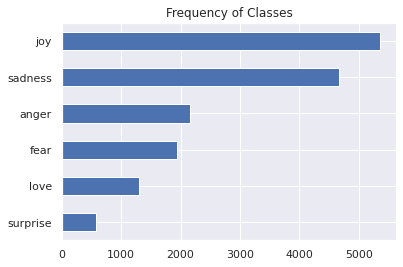

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_theme()

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [ ]:
emotions.reset_format()

# Tokenization

In [ ]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 70.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 53.2 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer 

checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(batch):
  return tokenizer(batch["text"], padding = True, truncation = True)

In [ ]:
print(tokenize_function(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [ ]:
tokenized_datasets = emotions.map(tokenize_function,
                                  batched = True,
                                  batch_size = None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
print(tokenized_datasets["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


# Modeling

In [ ]:
from transformers import AutoModelForSequenceClassification
import torch

checkpoint = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = (AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                            num_labels = 6).to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifi

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds=pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [ ]:
from huggingface_hub import notebook_login 
notebook_login()

Token is valid.
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.
Token has not been saved to git credential helper.
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir = "finetuning-emotion-model",
    num_train_epochs = 2,
    learning_rate = 2e-5,
    per_device_eval_batch_size=64,
    per_device_train_batch_size=64,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm= False,
    push_to_hub = True 
)

# Training

In [ ]:
from transformers import Trainer 

trainer = Trainer(
    model = model,
    args = training_args,
    compute_metrics = compute_metrics,
    train_dataset = tokenized_datasets["train"],
    eval_dataset = tokenized_datasets["validation"],
    tokenizer = tokenizer 
)

Cloning https://huggingface.co/Tirendaz/finetuning-emotion-model into local empty directory.


Download file pytorch_model.bin:   0%|          | 17.4k/255M [00:00<?, ?B/s]

Download file training_args.bin: 100%|##########| 3.43k/3.43k [00:00<?, ?B/s]

Download file runs/Feb12_08-52-20_6cd86fd09f7c/1676191949.7872565/events.out.tfevents.1676191949.6cd86fd09f7c.…

Download file runs/Feb12_08-52-20_6cd86fd09f7c/events.out.tfevents.1676191949.6cd86fd09f7c.1228.0: 100%|######…

Clean file training_args.bin:  29%|##9       | 1.00k/3.43k [00:00<?, ?B/s]

Clean file runs/Feb12_08-52-20_6cd86fd09f7c/1676191949.7872565/events.out.tfevents.1676191949.6cd86fd09f7c.122…

Clean file runs/Feb12_08-52-20_6cd86fd09f7c/events.out.tfevents.1676191949.6cd86fd09f7c.1228.0:  20%|#9       …

Download file runs/Feb12_12-51-54_d063d4927d18/events.out.tfevents.1676206408.d063d4927d18.199.0: 100%|#######…

Clean file runs/Feb12_12-51-54_d063d4927d18/events.out.tfevents.1676206408.d063d4927d18.199.0:  22%|##1       …

Download file runs/Feb12_12-51-54_d063d4927d18/1676206408.077937/events.out.tfevents.1676206408.d063d4927d18.1…

Clean file runs/Feb12_12-51-54_d063d4927d18/1676206408.077937/events.out.tfevents.1676206408.d063d4927d18.199.…

Clean file pytorch_model.bin:   0%|          | 1.00k/255M [00:00<?, ?B/s]

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 16000
  Num Epochs = 2
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 500
  Number of trainable parameters = 66958086
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster t

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.323506,0.903500,0.900333
2,0.538400,0.223829,0.920500,0.920432


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 64
Saving model checkpoint to finetuning-emotion-model/checkpoint-500
Configuration saved in finetuning-emotion-model/checkpoint-500/config.json
Model weights saved in finetuning-emotion-model/checkpoint-500/pytorch_model.bin
tokenizer config file saved in finetuning-emotion-model/checkpoint-500/tokenizer_config.json
Special tokens file saved in finetuning-emotion-model/checkpoint-500/special_tokens_map.json
tokenizer config file saved in finetuning-emotion-model/tokenizer_config.json
Special tokens file saved in finetuning-emotion-model/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBert

TrainOutput(global_step=500, training_loss=0.5383665771484375, metrics={'train_runtime': 250.5425, 'train_samples_per_second': 127.723, 'train_steps_per_second': 1.996, 'total_flos': 720342861696000.0, 'train_loss': 0.5383665771484375, 'epoch': 2.0})

# Pushing the Model to the Hugging Face Hub

In [ ]:
trainer.push_to_hub(commit_message = "Training completed")

Saving model checkpoint to finetuning-emotion-model
Configuration saved in finetuning-emotion-model/config.json
Model weights saved in finetuning-emotion-model/pytorch_model.bin
tokenizer config file saved in finetuning-emotion-model/tokenizer_config.json
Special tokens file saved in finetuning-emotion-model/special_tokens_map.json


Upload file runs/Feb12_16-58-53_e611389e199b/events.out.tfevents.1676221382.e611389e199b.138.0: 100%|#########…

remote: Scanning LFS files for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/Tirendaz/finetuning-emotion-model
   fb14901..c454e31  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Tirendaz/finetuning-emotion-model
   fb14901..c454e31  main -> main

To https://huggingface.co/Tirendaz/finetuning-emotion-model
   c454e31..2bb679a  main -> main

   c454e31..2bb679a  main -> main



'https://huggingface.co/Tirendaz/finetuning-emotion-model/commit/c454e317f1241a50c741aa98983c9c63f0932c57'

# Prediction

In [ ]:
from transformers import pipeline 

classifier = pipeline("text-classification", 
                      model="Tirendaz/finetuning-emotion-model")

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--Tirendaz--finetuning-emotion-model/snapshots/2bb679ae4ac968ded5b0c7879bb7d4a32ee76400/config.json
Model config DistilBertConfig {
  "_name_or_path": "Tirendaz/finetuning-emotion-model",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
 

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--Tirendaz--finetuning-emotion-model/snapshots/2bb679ae4ac968ded5b0c7879bb7d4a32ee76400/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the model checkpoint at Tirendaz/finetuning-emotion-model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForSequenceClassification for predictions without further training.


loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--Tirendaz--finetuning-emotion-model/snapshots/2bb679ae4ac968ded5b0c7879bb7d4a32ee76400/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--Tirendaz--finetuning-emotion-model/snapshots/2bb679ae4ac968ded5b0c7879bb7d4a32ee76400/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--Tirendaz--finetuning-emotion-model/snapshots/2bb679ae4ac968ded5b0c7879bb7d4a32ee76400/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--Tirendaz--finetuning-emotion-model/snapshots/2bb679ae4ac968ded5b0c7879bb7d4a32ee76400/tokenizer_config.json


In [ ]:
pred = classifier(["I love this move and it is really good"], 
                  return_all_scores = True)

/usr/local/lib/python3.8/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Disabling tokenizer parallelism, we're using DataLoader multithreading already


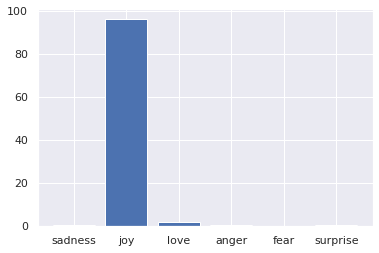

In [ ]:
import pandas as pd 

labels = emotions["train"].features["label"].names
df = pd.DataFrame(pred[0])
plt.bar(labels, 100 * df["score"])
plt.show()

Thanks for reading 😀 Let's connect [YouTube](http://youtube.com/tirendazacademy) | [Medium](http://tirendazacademy.medium.com) | [Twitter](http://twitter.com/tirendazacademy) | [Instagram](https://www.instagram.com/tirendazacademy) |[GitHub](http://github.com/tirendazacademy) | [Linkedin](https://www.linkedin.com/in/tirendaz-academy) | [Kaggle](https://www.kaggle.com/tirendazacademy) 😎